In [1]:
import pandas as pd
import numpy as np
import theano
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline
import pymc3 as pm
# Initialize random number generator
np.random.seed(123)

import os
from scipy.integrate import solve_ivp
from scipy.integrate import odeint



In [2]:
dirname = os.getcwd()
filename = dirname + '\..\data\\tumor_size_db.csv'

tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()


,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,53.973689,19.464756,27.939597,19.032486,44.872119,20.290405,38.955318,21.359080,30.988742,17.752230,42.366388,13.069455
1,14,56.730533,34.316923,47.079148,26.709641,59.175717,41.133786,39.697439,29.993253,34.640653,25.398323,52.488467,23.978783
2,23,90.677211,51.384002,61.140151,31.821015,112.524376,51.204812,75.404253,68.348904,61.905680,33.892752,118.747997,71.618255
3,29,182.971051,96.268908,127.343047,61.519414,211.247381,127.305794,217.351729,153.788112,134.994293,65.107710,182.961115,103.520392
4,34,284.888364,147.891820,225.843888,92.229404,346.168185,147.788359,388.344451,247.451969,257.324806,123.482982,267.228868,140.192699


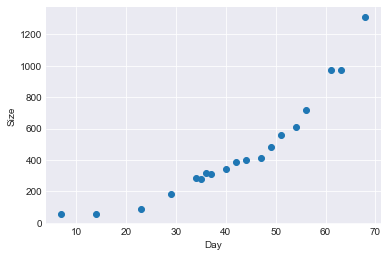

In [3]:
plt.scatter(tumor_size_db['Day'], tumor_size_db['G1_avg'])
plt.xlabel('Day')
plt.ylabel('Size')
plt.show()

53.97368929


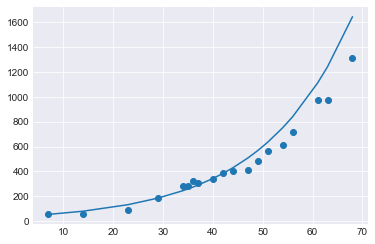

In [4]:
def dydt_exp_growth(t, y):
    return 0.056*y

#scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', 
#    t_eval=None, dense_output=False, events=None, vectorized=False, **options)[source]

print(tumor_size_db['G1_avg'][0])
sol = solve_ivp(dydt_exp_growth, [7,70], [tumor_size_db['G1_avg'][0]], t_eval=tumor_size_db['Day'])

plt.scatter(tumor_size_db['Day'], tumor_size_db['G1_avg'])
plt.plot(sol.t.reshape(-1,1), sol.y.reshape(-1,1))
plt.show()


In [5]:
class FitzhughNagumoModel(object):
    def __init__(self, times, y0=None):
            self._y0 = np.array([-1, 1], dtype=np.float64)
            self._times = times

    def _simulate(self, parameters, times):
        a, b, c = [float(x) for x in parameters]

        def rhs(y, t, p):
            V, R = y
            dV_dt = (V - V**3 / 3 + R) * c
            dR_dt = (V - a + b * R) / -c
            return dV_dt, dR_dt
        values = odeint(rhs, self._y0, times, (parameters,),rtol=1e-6,atol=1e-6)
        return values

    def simulate(self, x):
        return self._simulate(x, self._times)

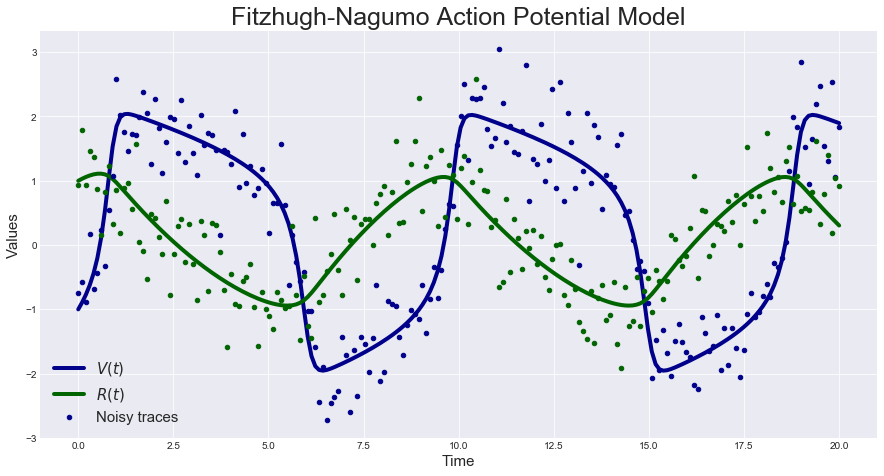

In [6]:
n_states = 2
n_times = 200
true_params = [0.2,0.2,3.]
noise_sigma = 0.5
FN_solver_times = np.linspace(0, 20, n_times)
ode_model = FitzhughNagumoModel(FN_solver_times)
sim_data = ode_model.simulate(true_params)
np.random.seed(42)
Y_sim = sim_data + np.random.randn(n_times,n_states)*noise_sigma
plt.figure(figsize=(15, 7.5))
plt.plot(FN_solver_times, sim_data[:,0], color='darkblue', lw=4, label=r'$V(t)$')
plt.plot(FN_solver_times, sim_data[:,1], color='darkgreen', lw=4, label=r'$R(t)$')
plt.plot(FN_solver_times, Y_sim[:,0], 'o', color='darkblue', ms=4.5, label='Noisy traces')
plt.plot(FN_solver_times, Y_sim[:,1], 'o', color='darkgreen', ms=4.5)
plt.legend(fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.title('Fitzhugh-Nagumo Action Potential Model', fontsize=25);

In [7]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dmatrix])
def th_forward_model(param1,param2,param3):

    param = [param1,param2,param3]
    th_states = ode_model.simulate(param)

    return th_states

In [ ]:
n_chains = 3               # WARNING: Always use n_chains >= 500 for real applications

with pm.Model() as FN_model:

    a = pm.Gamma('a', alpha=2, beta=1)
    b = pm.Normal('b', mu=0, sd=1)
    c = pm.Uniform('c', lower=0.1, upper=10)

    sigma = pm.HalfNormal('sigma', sd=1)

    forward = th_forward_model(a,b,c)

    cov=np.eye(2)*sigma**2


    Y_obs = pm.MvNormal('Y_obs', mu=forward, cov=cov, observed=Y_sim)

    # Initial points for each of the chains
    np.random.seed(21)
    startsmc=[{'a':np.random.uniform(1e-3,2,1),'b':np.random.uniform(1e-3,2,1),
            'c':np.random.uniform(1e-3,10,1),'sigma':np.random.uniform(1e-3,2)} for _ in range(n_chains)]

    trace_FN = pm.sample(1000, chains=n_chains, start=startsmc, step=pm.SMC())

Sample initial stage: ...
Stage: 0 Beta: 0.001 Steps: 25


Exponential growth model with odeint


In [8]:
class exp_growth_model(object):
    def __init__(self, times):
            self._y0 = tumor_size_db['G1_avg'][0]
            self._times = times

    def _simulate(self, parameters, times):
        a = [float(x) for x in parameters]

        def rhs(y, t, a):
            Y = y
            dY_dt = a*Y
            return dY_dt
        
        values = odeint(rhs, self._y0, times, (parameters,),rtol=1e-6,atol=1e-6)
        return values

    def simulate(self, x):
        return self._simulate(x, self._times)

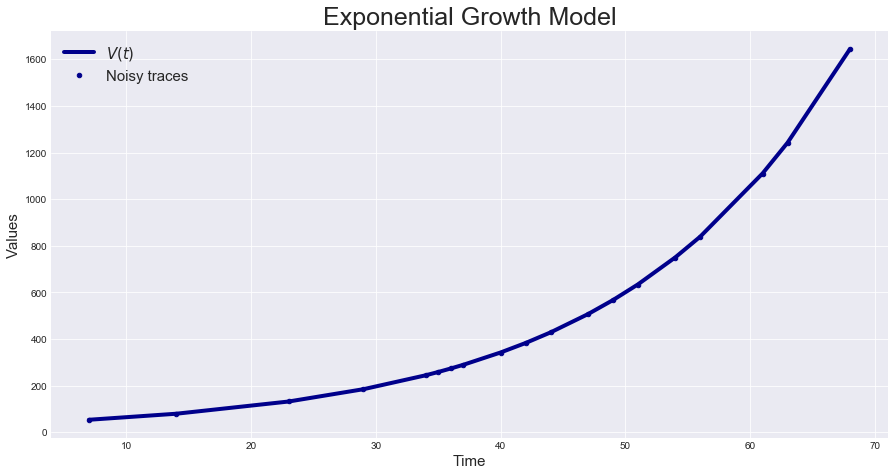

In [9]:
n_states = 1
n_times = 19
true_params = [0.056]
noise_sigma = 0.5
FN_solver_times = tumor_size_db['Day']
ode_model = exp_growth_model(FN_solver_times)
sim_data = ode_model.simulate(true_params)
np.random.seed(42)
Y_sim = sim_data + np.random.randn(n_times,n_states)*noise_sigma
plt.figure(figsize=(15, 7.5))
plt.plot(FN_solver_times, sim_data[:,0], color='darkblue', lw=4, label=r'$V(t)$')
#plt.plot(FN_solver_times, sim_data[:,1], color='darkgreen', lw=4, label=r'$R(t)$')
plt.plot(FN_solver_times, Y_sim[:,0], 'o', color='darkblue', ms=4.5, label='Noisy traces')
#plt.plot(FN_solver_times, Y_sim[:,1], 'o', color='darkgreen', ms=4.5)
plt.legend(fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.title('Exponential Growth Model', fontsize=25);

In [10]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix])
def th_forward_model(param1):

    param = [param1]
    th_states = ode_model.simulate(param)

    return th_states

In [11]:
n_chains = 1              # WARNING: Always use n_chains >= 500 for real applications

with pm.Model() as exp_growth_model:

    a = pm.Uniform('a', lower=0.04, upper=0.06)

    sigma = pm.HalfNormal('sigma', sd=1)

    forward = th_forward_model(a)


    Y_obs = pm.Normal('Y_obs', mu=forward, sigma = sigma, observed=Y_sim)

    # Initial points for each of the chains
    np.random.seed(123)
    
    trace = pm.sample(1000, chains=n_chains, cores=1, tune = 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [a]
>NUTS: [sigma]
100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [01:22<00:00, 13.36it/s]
The acceptance probability does not match the target. It is 0.9410245083793314, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


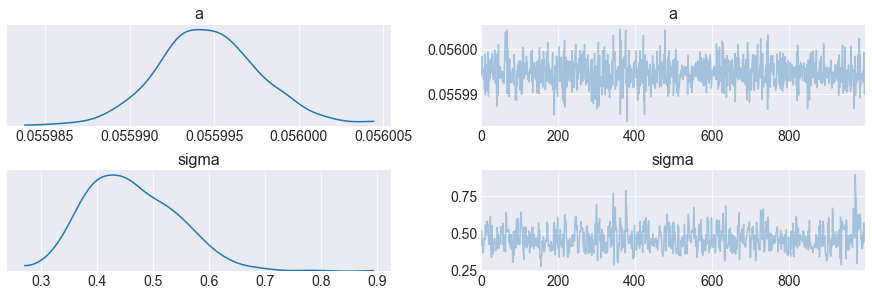

In [12]:
with exp_growth_model:
    pm.traceplot(trace)

Exponential growth model with runge kutta


In [18]:
def rungeKutta(ts, y0, dydt, params): 
    ys = np.zeros((len(ts),len(y0)))
    ys[0] = y0
    y = y0

    for i in range(1,(len(ts))) :
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        #print(t0)
        #print(y)
        #print(h)
        k1 = h * dydt(t0, y, params) 
        k2 = h * dydt(t0 + 0.5 * h, y + 0.5 * k1, params) 
        k3 = h * dydt(t0 + 0.5 * h, y + 0.5 * k2, params) 
        k4 = h * dydt(t0 + h, y + k3, params) 

        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        ys[i] = y

    return ys

class exp_growth_model(object):
    def __init__(self, times):
            self._y0 = tumor_size_db['G1_avg'][0]
            self._times = times

    def _simulate(self, params, times):
        
        def dydt(t, y, params):
            return params[0]*y[0]
        
        #values = odeint(rhs, self._y0, times, (parameters,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, [self._y0], dydt, params)
        return values

    def simulate(self, x):
        return self._simulate(x, self._times)

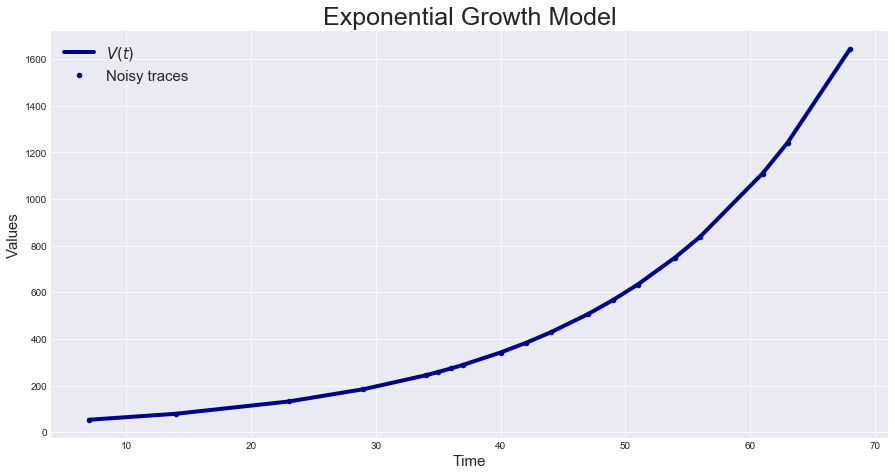

In [17]:
n_states = 1
n_times = 19
true_params = [0.056]
noise_sigma = 0.5
FN_solver_times = tumor_size_db['Day']
ode_model = exp_growth_model(FN_solver_times)
sim_data = ode_model.simulate(true_params)
np.random.seed(42)
Y_sim = sim_data + np.random.randn(n_times,n_states)*noise_sigma
plt.figure(figsize=(15, 7.5))
plt.plot(FN_solver_times, sim_data[:,0], color='darkblue', lw=4, label=r'$V(t)$')
#plt.plot(FN_solver_times, sim_data[:,1], color='darkgreen', lw=4, label=r'$R(t)$')
plt.plot(FN_solver_times, Y_sim[:,0], 'o', color='darkblue', ms=4.5, label='Noisy traces')
#plt.plot(FN_solver_times, Y_sim[:,1], 'o', color='darkgreen', ms=4.5)
plt.legend(fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.title('Exponential Growth Model', fontsize=25);

In [7]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix])
def th_forward_model(param1):

    param = [param1]
    th_states = ode_model.simulate(param)

    return th_states

In [8]:
n_chains = 1              # WARNING: Always use n_chains >= 500 for real applications
theano.config.exception_verbosity= 'high'


with pm.Model() as exp_growth_model:

    a = pm.Uniform('a', lower=0.04, upper=0.06)

    sigma = pm.HalfNormal('sigma', sd=1)

    forward = th_forward_model(a)


    Y_obs = pm.Normal('Y_obs', mu=forward, sigma = sigma, observed=Y_sim)

    # Initial points for each of the chains
    np.random.seed(123)
    
    trace = pm.sample(1000, chains=n_chains, cores=1, tune = 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [a]
>NUTS: [sigma]
100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [04:08<00:00, 19.23it/s]
The acceptance probability does not match the target. It is 0.9239516723474095, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


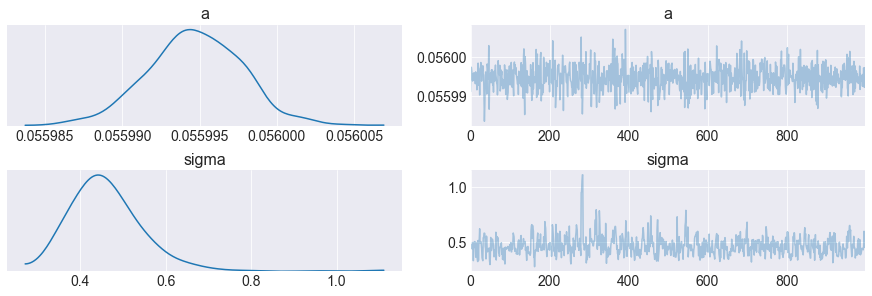

In [9]:
with exp_growth_model:
    pm.traceplot(trace)

In [14]:
alpha = np.sum(trace['a'][-100:])/100



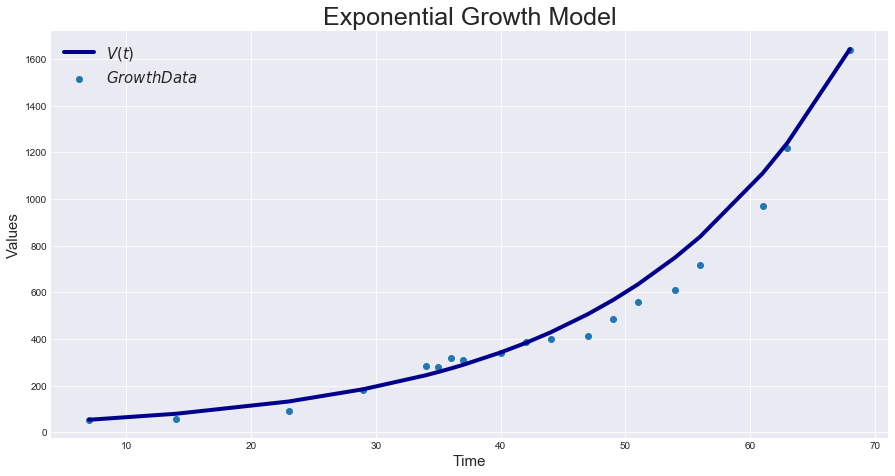

In [23]:

n_states = 1
n_times = 19
true_params = [alpha]
#noise_sigma = 0.5
FN_solver_times = tumor_size_db['Day']
ode_model = exp_growth_model(FN_solver_times)
sim_data = ode_model.simulate(true_params)

np.random.seed(42)
#Y_sim = sim_data + np.random.randn(n_times,n_states)*noise_sigma
plt.figure(figsize=(15, 7.5))



#real data
plt.scatter(tumor_size_db['Day'], tumor_size_db['G1_avg'], label=r'$Growth Data$')
plt.plot(FN_solver_times, sim_data[:,0], color='darkblue', lw=4, label=r'$V(t)$')


plt.legend(fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Values',fontsize=15)
plt.title('Exponential Growth Model', fontsize=25);

plt.show()

